In [21]:
!pip install google-api-python-client isodate pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from googleapiclient.discovery import build
import isodate


In [22]:
API_KEY = "api_key"
youtube = build("youtube", "v3", developerKey=API_KEY)


In [24]:
def get_video_ids(channel_id, max_results=50):
    request = youtube.search().list(
        part="id",
        channelId=channel_id,
        maxResults=max_results,
        order="date"
    )
    response = request.execute()
    return [item['id']['videoId'] for item in response['items'] if 'videoId' in item['id']]

def get_video_details(video_ids):
    all_data = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,statistics,contentDetails",
            id=",".join(video_ids[i:i+50])
        )
        response = request.execute()

        for item in response['items']:
            stats = item['statistics']
            snippet = item['snippet']
            content = item['contentDetails']

            all_data.append({
                "title": snippet['title'],
                "publishedAt": snippet['publishedAt'],
                "duration": content['duration'],
                "tags": len(snippet.get('tags', [])),
                "views": int(stats.get('viewCount', 0)),
                "likes": int(stats.get('likeCount', 0)) if 'likeCount' in stats else 0,
                "comments": int(stats.get('commentCount', 0)) if 'commentCount' in stats else 0
            })

    return pd.DataFrame(all_data)


In [25]:
channel_id = "UCX6OQ3DkcsbYNE6H8uQQuVA"

video_ids = get_video_ids(channel_id, max_results=50)
df = get_video_details(video_ids)

print("Fetched", len(df), "videos")
df.head()


Fetched 49 videos


,title,publishedAt,duration,tags,views,likes,comments
0,"Pick The Wrong Tube, Get Slimed",2025-08-27T16:00:02Z,PT36S,0,36420443,914289,3437
1,Reaction Time Challenge,2025-08-19T16:00:02Z,PT29S,0,78241858,1326895,9753
2,Every YouTube Play Button I Have,2025-08-15T16:00:01Z,PT15S,0,60647068,1592879,9638
3,"2,000,000 People Get Clean Water For The First...",2025-08-01T16:00:01Z,PT10M20S,0,62555598,2189125,41827
4,"Beat Neymar, Win $500,000",2025-05-24T16:00:01Z,PT27M53S,0,152136991,3493089,81132


In [26]:

def parse_duration_safe(x):
    try:
        return isodate.parse_duration(x).total_seconds() / 60
    except:
        return None

df['duration'] = df['duration'].apply(parse_duration_safe)

df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
df['publish_hour'] = df['publishedAt'].dt.hour
df['publish_day'] = df['publishedAt'].dt.dayofweek

df = df.dropna()

df.head()


,title,publishedAt,duration,tags,views,likes,comments,publish_hour,publish_day
0,"Pick The Wrong Tube, Get Slimed",2025-08-27 16:00:02+00:00,0.600000,0,36420443,914289,3437,16,2
1,Reaction Time Challenge,2025-08-19 16:00:02+00:00,0.483333,0,78241858,1326895,9753,16,1
2,Every YouTube Play Button I Have,2025-08-15 16:00:01+00:00,0.250000,0,60647068,1592879,9638,16,4
3,"2,000,000 People Get Clean Water For The First...",2025-08-01 16:00:01+00:00,10.333333,0,62555598,2189125,41827,16,4
4,"Beat Neymar, Win $500,000",2025-05-24 16:00:01+00:00,27.883333,0,152136991,3493089,81132,16,5


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df[['duration', 'tags', 'likes', 'comments', 'publish_hour', 'publish_day']]
y = df['views']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


R² Score: -0.42725777155687017
RMSE: 119424751.80311976


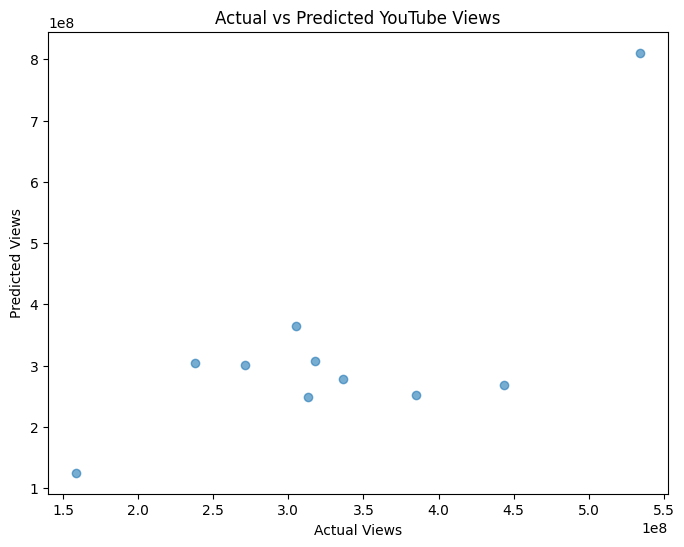

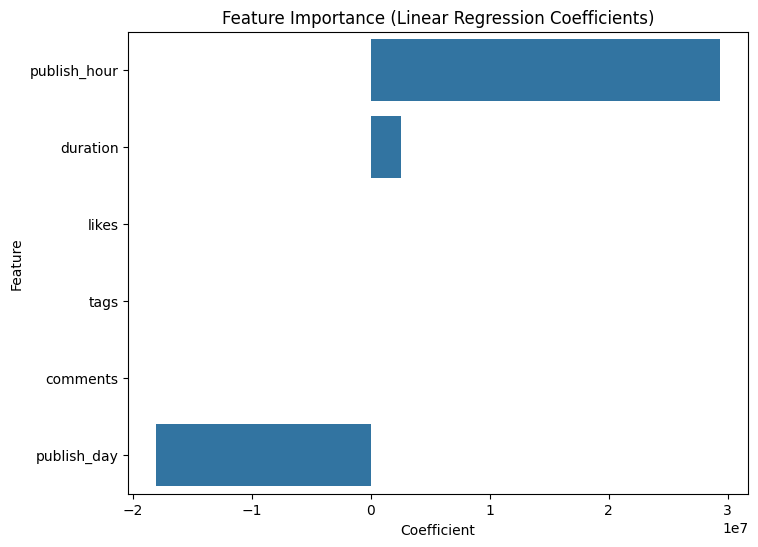

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Actual vs Predicted YouTube Views")
plt.show()

coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Coefficient", y="Feature", data=coeffs)
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.show()


In [31]:
y_pred = model.predict(X_test)

import numpy as np
y_pred_exp = np.expm1(y_pred)
y_test_exp = np.expm1(y_test)


/tmp/ipython-input-3568764909.py:4: RuntimeWarning: overflow encountered in expm1
  y_pred_exp = np.expm1(y_pred)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [39]:
y_test_safe = np.clip(y_test, -10, 20)
y_pred_safe = np.clip(y_pred, -10, 20)

y_test_exp = pd.Series(np.expm1(y_test_safe)).clip(lower=1)
y_pred_exp = pd.Series(np.expm1(y_pred_safe)).clip(lower=1)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


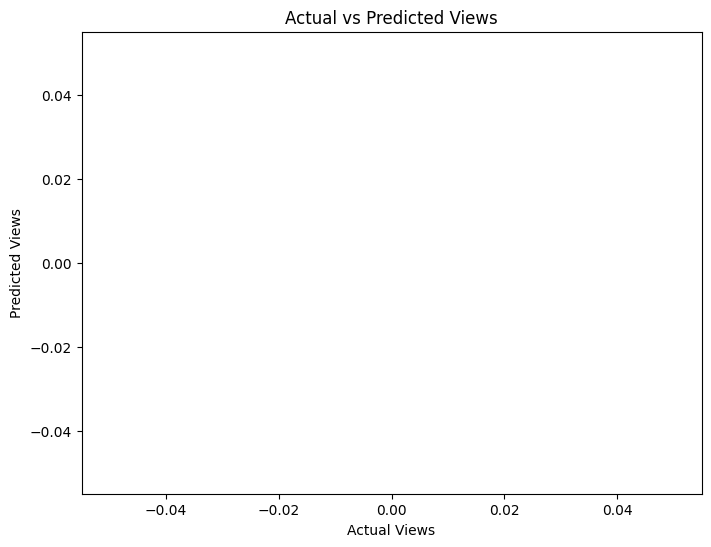

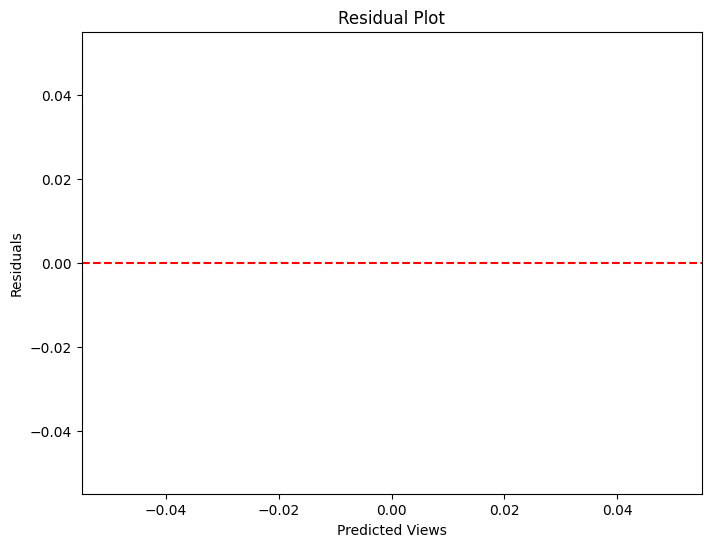

In [42]:
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)

y_test_exp = np.expm1(y_test).clip(lower=1)
y_pred_exp = np.expm1(y_pred).clip(lower=1)

residuals = y_test_exp - y_pred_exp

plt.figure(figsize=(8,6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.5)
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Actual vs Predicted Views")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_pred_exp, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Views")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


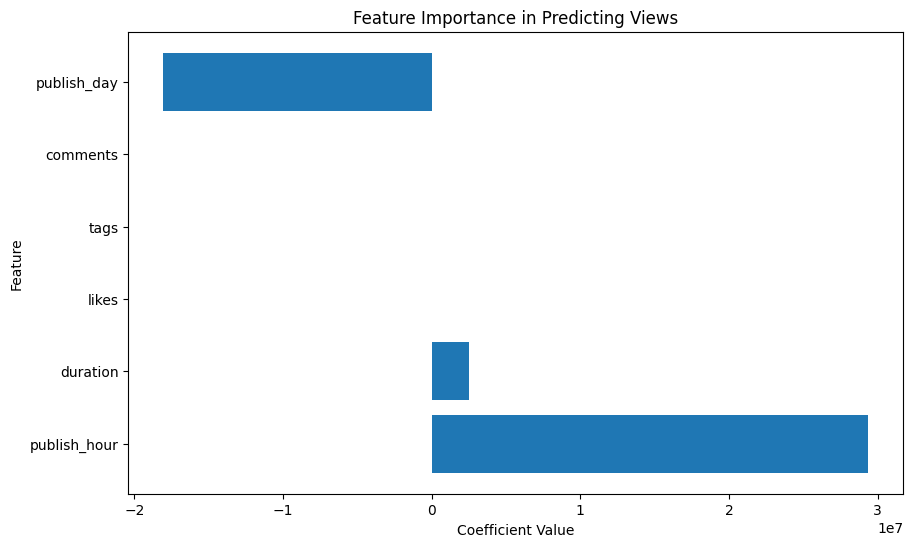

In [43]:
feature_names = X.columns
coef = model.coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coef
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(coef_df["Feature"], coef_df["Coefficient"])
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Views")
plt.show()


In [44]:
import joblib
joblib.dump(model, "youtube_views_model.pkl")


['youtube_views_model.pkl']